## Modelo CAPM

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

from datetime import datetime, timedelta
import pandas_datareader.data as web
from calendar import monthrange

In [2]:
# função que se a entrada for NaN toma o valor do dia anterior
def normalize_nan(df):
    for i in range(len(df)):
        if i == 0:
            pass
        elif math.isnan(df.iloc[i]) == True:
            df.iloc[i] = df.iloc[i-1]
        else:
            continue

In [3]:
# criando um dataframe com as datas diárias e com frequência trimestral de 01/01/2000 até hoje
date_today = datetime.now().date()
days = pd.date_range(start = '1995-01-01', end = date_today, freq='D')
months = pd.date_range(start = '1995-01-01', end = date_today, freq='MS')
# quarters = pd.date_range(start = '2012-06-30', end = date_today, freq='Q')

### IPCA

In [4]:
# função que recebe código do BC e devolve uma série de acordo
# códigos e séries podem ser encontrados em https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [5]:
# puxando dados do IPCA direto da base do Banco Central
ipca = pd.DataFrame(consulta_bc(433), index=months)

In [6]:
# normalizando os NaN
normalize_nan(ipca)

In [7]:
# transformando o índice que era a data em uma coluna
ipca['Data'] = ipca.index

In [8]:
# pegando apenas o mês e o ano da data
ipca['Data'] = ipca['Data'].dt.to_period('M')

In [9]:
# setando a nova data que tem apenas mês e ano como índice
ipca.set_index('Data', inplace=True)

A variação está em porcentagem. A interpretação desse valor é que os preços de determinado mês aumentaram/diminuiram $x$% em relação aos preços do mês passado. Dessa forma, é necessário escrever como

$$
    IPCA_{mensal} = \frac{x}{100}
$$

onde $x$ é o valor de variação mensal dos preços em porcentagem, em relação aos preços do mês passado.

In [10]:
# deixando o IPCA em forma decimal
ipca['IPCA_m'] = (ipca['valor']/100)

In [11]:
# deixando apenas a coluna de IPCA no dataframe
ipca = ipca[['IPCA_m']]

Os dados do IPCA são variações mensais, precisamos portanto anualizar

$$
IPCA_{anualizado} = (1+IPCA_{mensal})^{12} -1
$$

In [12]:
# anualizando o ipca
ipca['IPCA'] = (1 + ipca['IPCA_m'])**(12) - 1

In [13]:
# deixando apenas o IPCA mensal anualizado
ipca = ipca[['IPCA']]

In [14]:
# dataframe de IPCA pronto
ipca

,IPCA
Data,
1995-01,0.224197
1995-02,0.129506
1995-03,0.202705
1995-04,0.333909
1995-05,0.371901
...,...
2022-08,-0.042355
2022-09,-0.034250
2022-10,0.073143


### Ativo livre de risco

In [15]:
# puxando os retornos dos títulos como ativo livre de risco
bills = pd.read_csv('bills.csv', sep=';')

In [16]:
# transformando a coluna de data (objeto em forma de string) em um objeto de data
bills['date'] = pd.to_datetime(bills['date'], dayfirst=True)

In [17]:
# deixando as datas com apenas mês e ano
bills['date'] = bills['date'].dt.to_period('M')

In [18]:
# setando como índice essa nova data
bills.set_index('date', inplace=True)

In [19]:
# tratando os valores do ativo livre de risco
bills['rf'] = bills['rf'].str.replace(',','.')

In [20]:
# transformando em um objeto do tipo float
bills['rf'] = bills['rf'].astype(float)

In [21]:
# deixando em forma decimal
bills = bills/100

Os valores dos retornos do ativo livre de risco já estão anualizados

In [22]:
# retorno do ativo livre de risco pronto
bills

,rf
date,
1995-01,0.424101
1995-02,0.466142
1995-03,0.497112
1995-04,0.845738
1995-05,0.593658
...,...
2022-04,0.130709
2022-05,0.134349
2022-06,0.134772


### Ibovespa

In [23]:
# puxando dados do Ibovespa
ibov = web.get_data_yahoo('^BVSP', start = "1995-01-01")

In [24]:
# transformando índice de datas em coluna
ibov['Data'] = ibov.index

In [25]:
# pegando apenas o dado do ibovespa do primeiro dia do mês
ibov = ibov.resample("M", on='Data').first().reset_index(drop=True)

In [26]:
# transformando a data apenas em mês e ano
ibov['Data'] = ibov['Data'].dt.to_period('M')

In [27]:
# setando como índice essa nova data
ibov.set_index('Data', inplace=True)

In [28]:
# deixando apenas o preço
ibov = ibov[['Adj Close']]

In [29]:
# preço em t-1
ibov['P_t-1'] = ibov['Adj Close'].shift(1)

Os retornos do Ibovespa são obtidos através de

$$
r_{M} = \frac{P_t^{M} - P_{t-1}^M}{P_{t-1}^M}
$$

In [30]:
# retornos do Ibovespa
ibov['Ibovespa'] = (ibov['Adj Close'] - ibov['P_t-1'])/ibov['P_t-1']

In [31]:
# ficando com apenas os retornos do ibovespa
ibov = ibov[['Ibovespa']]

In [32]:
# retornos anualizados do Ibovespa
ibov = (1 + ibov)**(12) - 1

In [33]:
# retorno do ibovespa pronto
ibov

,Ibovespa
Data,
1995-01,NaN
1995-02,-0.593949
1995-03,-0.968734
1995-04,-0.322988
1995-05,30.914690
...,...
2022-08,0.477356
2022-09,1.518718
2022-10,0.835049


### Carteiras de ações

O arquivo das carteiras de ações foram deixados preparados anteriormente. A partir dos dados de Market Cap (marketcap.csv) e preços dos ativos (stock), foram formadas as cinco carteiras conforme pedido

- Ações em 02 de janeiro com market cap nos $20 \%$ inferiores da B3, isso é, a ação com menor valor de capitalização até a ação no percentil 20.
- Ações em 02 de janeiro com market cap entre 20\% e $40 \%$.
- Ações em 02 de janeiro com market cap entre $40 \%$ e $60 \%$.
- Ações em 02 de janeiro com market cap entre $60 \%$ e $80 \%$.
- Ações em 02 de janeiro com market cap entre 80\% e 100\%.

denominado no dataframe como p20 (1º percentil), p40 (2º percentil), p60 (3º percentil), p80 (4º percentil) e p100 (5º percentil), respectivamente.

In [34]:
# puxando carteira de ações já separadas em percentis
carteiras = pd.read_csv('carteiras.csv', sep=';')

In [35]:
# renomeando as colunas
carteiras = carteiras.rename(
    columns={'Unnamed: 0': 'Data', '1 Percentil': 'p20', '2 Percentil':'p40', '3 Percentil':'p60', '4 Percentil':'p80', '5 Percentil':'p100'})

In [36]:
# transformando em um objeto de data
carteiras['Data'] = pd.to_datetime(carteiras['Data'], dayfirst=True)

In [37]:
# pegando apenas mês e ano da data
carteiras['Data'] = carteiras['Data'].dt.to_period('M')

In [38]:
# setando data como índice
carteiras.set_index('Data', inplace=True)

In [39]:
# anualizando as taxas
carteiras = (1 + carteiras)**(12) - 1

In [40]:
carteiras

,p20,p40,p60,p80,p100
Data,,,,,
1995-01,NaN,NaN,NaN,NaN,NaN
1995-02,-0.185967,-0.586773,0.036600,-0.637101,-0.637101
1995-03,-0.721313,-0.505530,-0.655608,-0.698156,-0.713782
1995-04,-0.124300,-0.417233,-0.339724,-0.732271,-0.660098
1995-05,0.735243,0.715458,0.049070,0.442461,3.522272
...,...,...,...,...,...
2020-08,0.195618,0.735243,0.493642,0.459340,0.619604
2020-09,-0.035412,0.074424,-0.046958,0.238721,0.528682
2020-10,-0.306158,-0.155649,0.209830,0.298407,0.392892


### Nominal para Real


Para transformar taxas nominais em reais, precisamos utilizar a inflação e usar a seguinte formula:

$$
1+r = \frac{1+i}{1+\pi}
$$

onde $r$ é a taxa real, $i$ a taxa nominal e $\pi$ a taxa de inflação.

### Ibovespa real

In [41]:
# unindo os dataframes do ibovespa com ipca
ibov_real = pd.concat([ibov, ipca], axis=1, join="inner")

In [42]:
# transformando dados nominais em reais
ibov_real['Ibovespa_Real'] = ((1+ibov_real['Ibovespa'])/(1+ibov_real['IPCA'])) - 1

In [43]:
# deixando apenas os retornos do ibovespa real
ibov_real = ibov_real[['Ibovespa_Real']]

In [44]:
ibov_real

,Ibovespa_Real
Data,
1995-01,NaN
1995-02,-0.640506
1995-03,-0.974004
1995-04,-0.492460
1995-05,22.263116
...,...
2022-08,0.542697
2022-09,1.608044
2022-10,0.709976


### Ativo livre de risco real

In [45]:
# unindo os dataframes da taxa livre de risco com o ipca
bills_real = pd.concat([bills, ipca], axis=1, join="inner")

In [46]:
# deixando as taxas em termos reais
bills_real['rf_Real'] = ((1+bills_real['rf'])/(1+bills_real['IPCA'])) - 1

In [47]:
# deixando apenas a taxa livre de risco real
bills_real = bills_real[['rf_Real']]

In [48]:
bills_real

,rf_Real
1995-01,0.163293
1995-02,0.298039
1995-03,0.244788
1995-04,0.383707
1995-05,0.161643
...,...
2022-04,-0.003679
2022-05,0.072284
2022-06,0.047388
2022-07,0.236665


### Carteira de ações reais

In [49]:
# unindo os dataframes das carteiras e o ipca
carteiras_real = pd.concat([carteiras, ipca], axis=1, join="inner")

In [50]:
# deixando as carteiras em termos reais
carteiras_real['p20_real'] = (1+carteiras_real['p20'])/(1+carteiras_real['IPCA']) - 1
carteiras_real['p40_real'] = (1+carteiras_real['p40'])/(1+carteiras_real['IPCA']) - 1
carteiras_real['p60_real'] = (1+carteiras_real['p60'])/(1+carteiras_real['IPCA']) - 1
carteiras_real['p80_real'] = (1+carteiras_real['p80'])/(1+carteiras_real['IPCA']) - 1
carteiras_real['p100_real'] = (1+carteiras_real['p100'])/(1+carteiras_real['IPCA']) - 1

In [51]:
# ficando apenas com os retornos reais
carteiras_real = carteiras_real[['p20_real', 'p40_real', 'p60_real', 'p80_real', 'p100_real']]

In [52]:
carteiras_real

,p20_real,p40_real,p60_real,p80_real,p100_real
Data,,,,,
1995-01,NaN,NaN,NaN,NaN,NaN
1995-02,-0.279301,-0.634152,-0.082253,-0.678710,-0.678710
1995-03,-0.768283,-0.588868,-0.713652,-0.749029,-0.762021
1995-04,-0.343508,-0.563113,-0.505007,-0.799290,-0.745183
1995-05,0.264845,0.250424,-0.235316,0.051432,2.296354
...,...,...,...,...,...
2020-08,0.161716,0.686038,0.451289,0.417959,0.573679
2020-09,-0.106500,-0.004759,-0.117196,0.147429,0.416020
2020-10,-0.373915,-0.238104,0.091684,0.171610,0.256868


### Juntando os dados

In [53]:
df = pd.concat([ibov_real, bills_real, carteiras_real], axis=1, join="inner")

In [54]:
df

,Ibovespa_Real,rf_Real,p20_real,p40_real,p60_real,p80_real,p100_real
1995-01,NaN,0.163293,NaN,NaN,NaN,NaN,NaN
1995-02,-0.640506,0.298039,-0.279301,-0.634152,-0.082253,-0.678710,-0.678710
1995-03,-0.974004,0.244788,-0.768283,-0.588868,-0.713652,-0.749029,-0.762021
1995-04,-0.492460,0.383707,-0.343508,-0.563113,-0.505007,-0.799290,-0.745183
1995-05,22.263116,0.161643,0.264845,0.250424,-0.235316,0.051432,2.296354
...,...,...,...,...,...,...,...
2020-08,1.161135,-0.006740,0.161716,0.686038,0.451289,0.417959,0.573679
2020-09,-0.142778,-0.053279,-0.106500,-0.004759,-0.117196,0.147429,0.416020
2020-10,-0.599606,-0.069593,-0.373915,-0.238104,0.091684,0.171610,0.256868
2020-11,-0.088589,-0.081766,-0.303029,-0.022366,-0.173556,-0.010652,-0.909305


#### Problema 1. 
Usando a abordagem de séries amostrais e supondo que o Ibovespa é a carteira de mercado, teste o CAPM usando como asset tests as 5 carteiras formadas pelo ordenamento do market cap. Nesse teste, a taxa sem risco deve ser a taxa de retorno mensal (anualizada) de LTNs de um mês.
Testado o modelo, o próximo passo é visualizar o teste através de um gráfico. Para tanto, obtenha, para cada carteira, o par da média do seu prêmio (retorno da carteira menos taxa sem risco) no período amostral e do beta estimado pela regressão da abordagem de série de tempo. Plote um gráfico com os cinco pares de observações e a reta prevista pelo modelo, 

$$
\mathbb{E}\left[R^i\right]-R^0=\beta\left(\mathbb{E}\left[R^M\right]-R^0\right)
$$

sendo a inclinação da reta determinada pelo prêmio médio do mercado na amostra. Qual é a carteira cujo retorno esperado é mais bem explicado pelo $\beta$ ? Qual é a carteira que o CAPM prevê com menor precisão o retorno esperado? Explique as suas respostas.

In [55]:
ols = pd.DataFrame()

In [56]:
ols['y'] = df['p20_real'] - df['rf_Real']
ols['x'] = df['Ibovespa_Real'] - df['rf_Real']
result = sm.ols(formula="y ~ x", data=ols).fit()

In [57]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     18.48
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           2.30e-05
Time:                        18:11:07   Log-Likelihood:                -616.11
No. Observations:                 311   AIC:                             1236.
Df Residuals:                     309   BIC:                             1244.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4466      0.104      4.296      0.0

O teste sobre o modelo pode ser verificado em cima do coeficiente do intercepto $\alpha$. No caso de $\alpha = 0$, há um bom ajuste dos dados ao modelo do CAPM. A estatística $t = 4.296$ com um p-value $= 0.000$ nos diz que o intercepto é estatísticamente diferente de 0 para níveis de significância usuais. Isso significa que não há um bom ajuste dos dados ao modelo CAPM.

In [58]:
beta20 = result.params[1]
m20 = (df['p20_real'] - df['rf_Real']).mean()

In [59]:
# visualização melhor de gráficos
sns.set(rc={'figure.figsize':(12,8)});

Text(0.5, 1.0, 'Carteira do Primeiro Percentil')

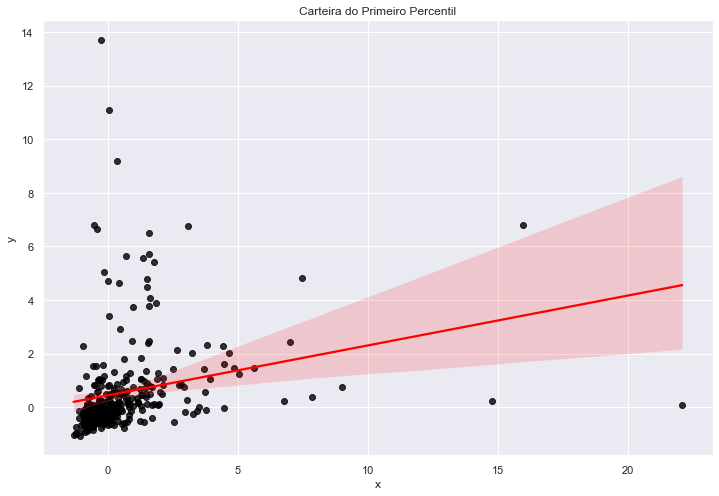

In [60]:
# Gráfico da carteira do primeiro percentil
sns.regplot(data=ols, x='x', y='y', scatter_kws={"color": "black"}, line_kws={"color": "red"}).set_title('Carteira do Primeiro Percentil')

In [61]:
ols['y'] = df['p40_real'] - df['rf_Real']
ols['x'] = df['Ibovespa_Real'] - df['rf_Real']
result = sm.ols(formula="y ~ x", data=ols).fit()

In [62]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     57.17
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           4.59e-13
Time:                        18:11:09   Log-Likelihood:                -476.92
No. Observations:                 311   AIC:                             957.8
Df Residuals:                     309   BIC:                             965.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2064      0.066      3.106      0.0

A estatística $t = 3.106$ com um p-value $= 0.002$ nos diz que o intercepto é estatísticamente diferente de 0 para níveis usuais de significância. Isso significa que não há um bom ajuste dos dados ao modelo CAPM.

In [63]:
beta40 = result.params[1]
m40 = (df['p40_real'] - df['rf_Real']).mean()

Text(0.5, 1.0, 'Carteira do Segundo Percentil')

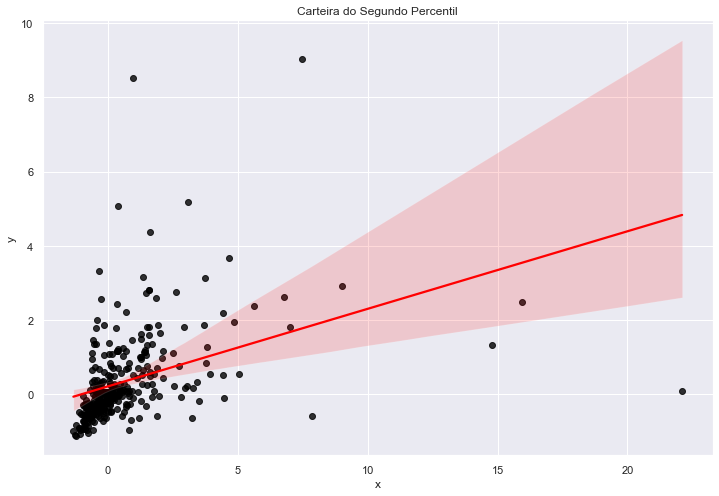

In [64]:
# Gráfico da carteira do segundo percentil
sns.regplot(data=ols, x='x', y='y', scatter_kws={"color": "black"}, line_kws={"color": "red"}).set_title('Carteira do Segundo Percentil')

In [65]:
ols['y'] = df['p60_real'] - df['rf_Real']
ols['x'] = df['Ibovespa_Real'] - df['rf_Real']
result = sm.ols(formula="y ~ x", data=ols).fit()

In [66]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     70.15
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.95e-15
Time:                        18:11:10   Log-Likelihood:                -536.21
No. Observations:                 311   AIC:                             1076.
Df Residuals:                     309   BIC:                             1084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1453      0.080      1.806      0.0

A estatística $t = 1.806$ com um p-value $= 0.072$ nos diz que o intercepto não é estatísticamente diferente de 0 para um nível de significância de 5%.

In [67]:
beta60 = result.params[1]
m60 = (df['p60_real'] - df['rf_Real']).mean()

Text(0.5, 1.0, 'Carteira do Terceiro Percentil')

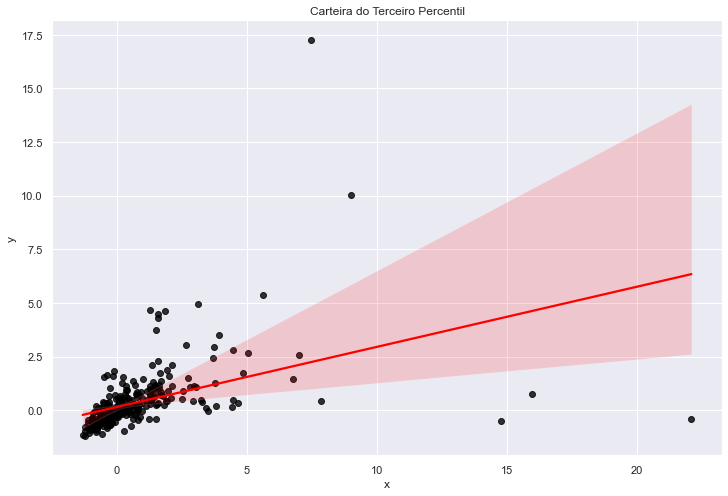

In [68]:
# Gráfico da carteira do terceiro percentil
sns.regplot(data=ols, x='x', y='y', scatter_kws={"color": "black"}, line_kws={"color": "red"}).set_title('Carteira do Terceiro Percentil')

In [69]:
ols['y'] = df['p80_real'] - df['rf_Real']
ols['x'] = df['Ibovespa_Real'] - df['rf_Real']
result = sm.ols(formula="y ~ x", data=ols).fit()

In [70]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     125.8
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.02e-24
Time:                        18:11:11   Log-Likelihood:                -462.75
No. Observations:                 311   AIC:                             929.5
Df Residuals:                     309   BIC:                             937.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0832      0.063      1.311      0.1

A estatística $t = 1.311$ com um p-value $= 0.191$ nos diz que o intercepto não é estatísticamente diferente de 0 para quaisquer níveis de significância usuais. Isso significa que há um bom ajuste ao modelo CAPM.

In [71]:
beta80 = result.params[1]
m80 = (df['p80_real'] - df['rf_Real']).mean()

Text(0.5, 1.0, 'Carteira do Quarto Percentil')

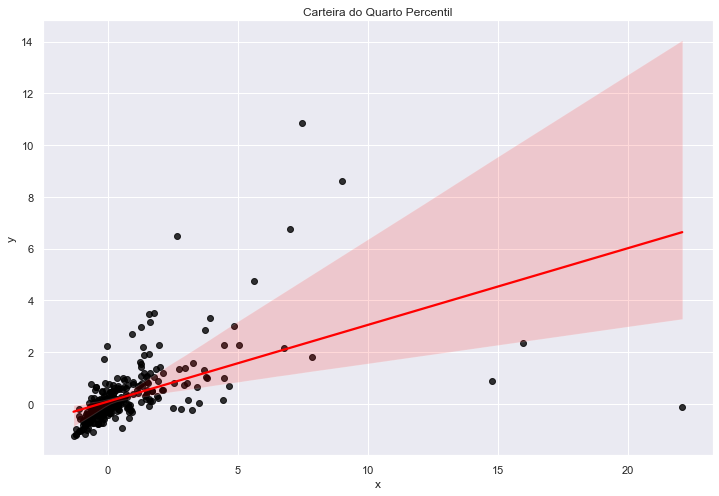

In [72]:
# Gráfico da carteira do quarto percentil
sns.regplot(data=ols, x='x', y='y', scatter_kws={"color": "black"}, line_kws={"color": "red"}).set_title('Carteira do Quarto Percentil')

In [73]:
ols['y'] = df['p100_real'] - df['rf_Real']
ols['x'] = df['Ibovespa_Real'] - df['rf_Real']
result = sm.ols(formula="y ~ x", data=ols).fit()

In [74]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     261.2
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           5.23e-43
Time:                        18:11:12   Log-Likelihood:                -417.73
No. Observations:                 311   AIC:                             839.5
Df Residuals:                     309   BIC:                             846.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0576      0.055      1.049      0.2

A estatística $t = 1.049$ com um p-value $= 0.295$ nos diz que o intercepto não é estatísticamente diferente de 0 para quaisquer níveis de significância usuais. Isso significa que há um bom ajuste ao modelo CAPM.

In [75]:
beta100 = result.params[1]
m100 = (df['p100_real'] - df['rf_Real']).mean()

Text(0.5, 1.0, 'Carteira do Quinto Percentil')

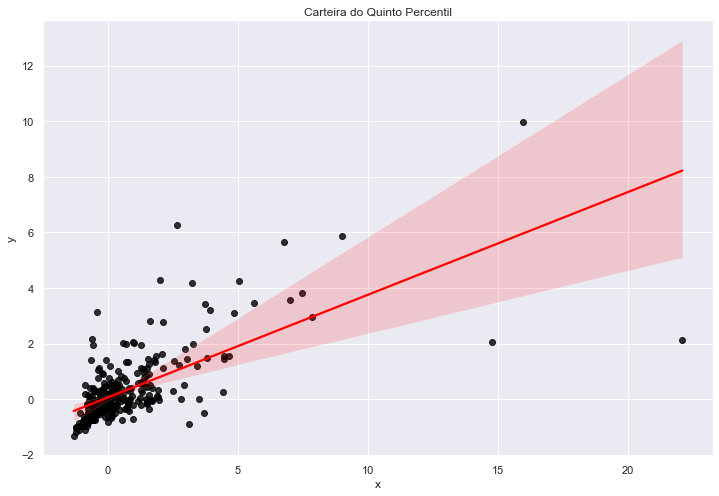

In [76]:
# Gráfico da carteira do quinto percentil
sns.regplot(data=ols, x='x', y='y', scatter_kws={"color": "black"}, line_kws={"color": "red"}).set_title('Carteira do Quinto Percentil')

In [77]:
betas = [beta20, beta40, beta60, beta80, beta100]
excesso_retornos = [m20, m40, m60, m80, m100]
betas_capm = {'Excesso de Retorno': excesso_retornos, 'Beta': betas}
betas_capm = pd.DataFrame(data=betas_capm, index= ['carteira20', 'carteira40', 'carteira60', 'carteira80', 'carteira100'])

In [78]:
media_excesso_retorno_mercado = (df['Ibovespa_Real'] - df['rf_Real']).mean()

In [79]:
beta = np.linspace(0, 0.5, 300)

In [80]:
line_capm = media_excesso_retorno_mercado*beta

In [81]:
betas_capm

,Excesso de Retorno,Beta
carteira20,0.571952,0.186044
carteira40,0.347307,0.209152
carteira60,0.334106,0.280335
carteira80,0.282876,0.296395
carteira100,0.306566,0.369560


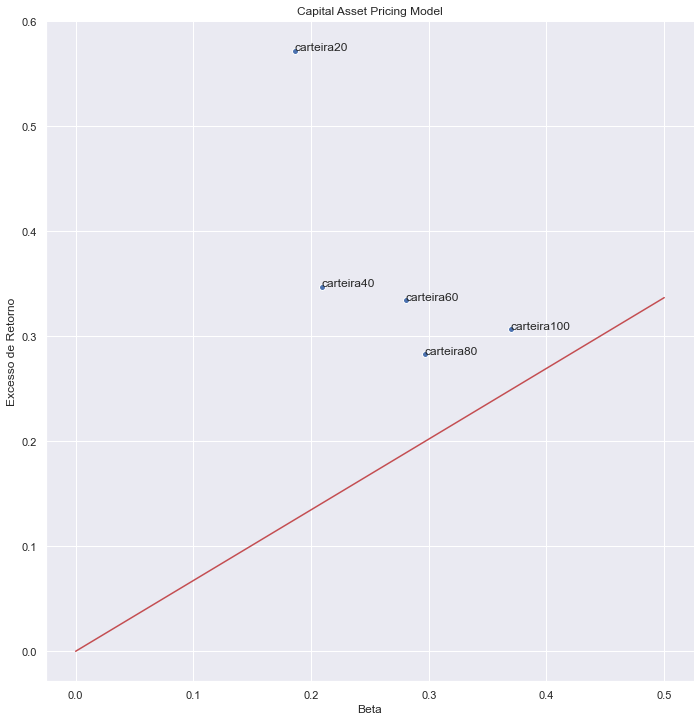

In [82]:
g = sns.FacetGrid(betas_capm, height = 10)
g = g.map(plt.scatter, "Beta","Excesso de Retorno", edgecolor="w")
for idx, row in betas_capm.iterrows(): 
    plt.text(row['Beta'], row['Excesso de Retorno'], idx)
plt.plot(beta, line_capm, color='r')
plt.title('Capital Asset Pricing Model')
plt.show()

Assim como os resultados nos testes, o gráfico mostra que os pontos das carteiras cujo Market cap é menor estão mais longe da linha de regressão do CAPM.

#### Problema 2. 
Usando a abordagem do cross-section e supondo que o Ibovespa é a carteira de mercado, teste o CAPM usando como test assets as 5 carteiras formadas pelo ordenamento do market cap. Nesse teste, a taxa sem risco deve ser a taxa de retorno mensal (anualizada) de LTNs de um mês.
Testado o modelo, o próximo passo é visualizar o teste através de um gráfico. Para tanto, obtenha, para cada carteira, o par da média do seu prêmio (retorno da carteira menos taxa sem risco) no período amostral e do beta estimado pelo teste da abordagem do cross-section. Plote um gráfico com os cinco pares de observações e a reta prevista pelo modelo, 

$$
E\left[R^i\right]-R^0=\beta \hat{\lambda}_M
$$
sendo a inclinação da reta determina pela estimativa de $\hat{\lambda}_M$ na regressão do cross-section. Qual é a carteira cujo retorno esperado é mais bem explicado pelo $\beta$ ? Qual é a carteira que o CAPM prevê com menor precisão o retorno esperado? Explique as suas respostas.

O modelos nada mais é do que

$$
\sum_{t=0}^T\left\{\frac{R_t^i-R_t^0}{T}\right\}=\hat{\beta}_{i 1} \lambda_1+u_i
$$

Isso significa que a variável explicada agora é o excesso de retorno médio de cada carteira, e agora a variável explicativa é o $\hat{\beta}$ estimado nas regressões do Problema (1).

In [83]:
ols = pd.DataFrame()
ols['y'] = betas_capm['Excesso de Retorno']
ols['x'] = betas_capm['Beta']
result = sm.ols(formula="y ~ x", data=ols).fit()

In [84]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     3.242
Date:                Tue, 13 Dec 2022   Prob (F-statistic):              0.170
Time:                        18:11:14   Log-Likelihood:                 6.0487
No. Observations:                   5   AIC:                            -8.097
Df Residuals:                       3   BIC:                            -8.878
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6759      0.176      3.847      0.0

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Para testar qual carteira tem o menor ajuste na abordagem Cross-Section, vamos utilizar os resíduos de cada amostra para responder tal pegunta, onde

$$
\hat{u}_i = E\left[R^i\right]-R^0 - \beta_i \hat{\lambda}_M - \alpha
$$

In [85]:
alpha = result.params[0]
lambda_chapeu = result.params[1]

In [86]:
betas_capm['u'] = betas_capm['Excesso de Retorno'] - betas_capm['Beta']*lambda_chapeu - alpha

In [87]:
betas_capm

,Excesso de Retorno,Beta,u
carteira20,0.571952,0.186044,0.109174
carteira40,0.347307,0.209152,-0.089002
carteira60,0.334106,0.280335,-0.020666
carteira80,0.282876,0.296395,-0.053501
carteira100,0.306566,0.369560,0.053996


Como as carteiras com os dois menores Market Cap têm, em valores absolutos, o maior resíduo, então essas foram as que tiveram menor precisão. Enquanto a carteira com o Market Cap mediano tem o menor resíduo, então esta tem o seu excesso de retorno mais bem explicado por $\beta$.

Text(0.5, 1.0, 'CAPM Cross-Section')

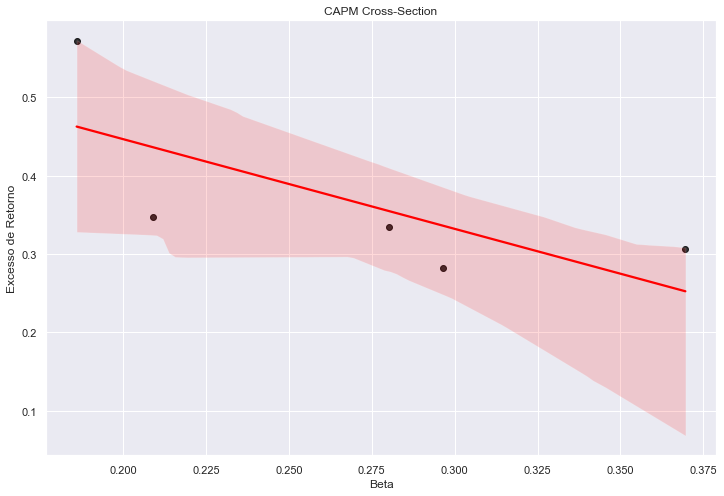

In [88]:
# Gráfico do CAPM na abordagem de Cross-Section
sns.regplot(data=betas_capm, x='Beta', y='Excesso de Retorno', scatter_kws={"color": "black"}, line_kws={"color": "red"}).set_title('CAPM Cross-Section')

#### Problema 3.
Usando Fama-MacBeth e supondo que o Ibovespa é a carteira de mercado, teste o CAPM usando como test assets as 5 carteiras formadas pelo ordenamento do market cap. Nesse teste, a taxa sem risco deve ser a taxa de retorno mensal (anualizada) de LTNs de um mês.

Neste problema, o modelo de múltiplos Betas de Fama e MacBeth, nesse contexto se dá na análise da seguinte regressão

$$
E\left[R^M\right]-R^0 = \beta_1 \left(\mathbb{E}\left[R^1\right]-R^0\right) + \beta_2 \left(\mathbb{E}\left[R^2\right]-R^0\right) + \beta_3 \left(\mathbb{E}\left[R^3\right]-R^0\right) + \beta_4 \left(\mathbb{E}\left[R^4\right]-R^0\right) + \beta_5 \left(\mathbb{E}\left[R^5\right]-R^0\right)
$$

onde $R^1$, $R^2$, $R^3$, $R^4$ e $R^5$ são respectivamente, os retornos das carteiras do primeiro, segundo, terceiro, quarto e quinto percentil.

In [89]:
ols = pd.DataFrame()

ols['y'] = df['Ibovespa_Real'] - df['rf_Real']
ols['x1'] = df['p20_real'] - df['rf_Real']
ols['x2'] = df['p40_real'] - df['rf_Real']
ols['x3'] = df['p60_real'] - df['rf_Real']
ols['x4'] = df['p80_real'] - df['rf_Real']
ols['x5'] = df['p100_real'] - df['rf_Real']

result = sm.ols(formula="y ~ x1 + x2 + x3 + x4 + x5", data=ols).fit()

In [90]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     55.15
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.06e-40
Time:                        18:11:15   Log-Likelihood:                -601.03
No. Observations:                 311   AIC:                             1214.
Df Residuals:                     305   BIC:                             1236.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2347      0.102      2.303      0.0

O único coeficiente estatisticamente significativo é o para o excesso de retorno da carteira do quinto percentil, isto é, a carteira de maior Market Cap. Esse resultado é compatível com o esperado.